# Stable Diffusion: Fine-tuning with DreamBooth

1. [Set Up](#1.-Set-Up) 
2. [Run inference on the pre-trained model that is unaware of Molly the dog](#2.-Run-inference-on-the-pre-trained-model)
    * [Select a model](#2.1.-Select-a-Model)
    * [Retrieve JumpStart Artifacts & Deploy an Endpoint](#2.2.-Retrieve-JumpStart-Artifacts-&-Deploy-an-Endpoint)
    * [Query endpoint and parse response](#2.3.-Query-endpoint-and-parse-response)
    * [Supported Inference parameters](#2.4.-Supported-Inference-parameters)
    * [Compressed Image Output](#2.5.-Compressed-Image-Output)
    * [Prompt Engineering](#2.6.-Prompt-Engineering)
    * [Negative Prompting](#2.7.-Negative-Prompting)
    * [Clean up the endpoint](#2.8.-Clean-up-the-endpoint)

3. [Fine-tune the pre-trained model on a custom dataset](#3.-Fine-tune-the-pre-trained-model-on-a-custom-dataset)
    * [Retrieve Training Artifacts](#3.1.-Retrieve-Training-Artifacts)
    * [Set Training parameters](#3.2.-Set-Training-parameters)
    * [Start Training](#3.3.-Start-Training)
    * [Deploy and run inference on the fine-tuned model](#3.4.-Deploy-and-run-inference-on-the-fine-tuned-model)

4. [Conclusion](#4.-Conclusion)


Note: This notebook is derived from a notebook generated by Amazon SageMaker JumpStart.

Note: This notebook was tested on ml.t3.medium instance in Amazon SageMaker Studio with Python 3 (Data Science) kernel and in Amazon SageMaker Notebook instance with conda_python3 kernel.

Note: To deploy the pre-trained or fine-tuned model, you can use `ml.p3.2xlarge` or `ml.g4dn.2xlarge` instance types. If `ml.g5.2xlarge` is available in your region, we recommend using that instance type for deployment. For fine-tuning the model on your dataset, you need `ml.g4dn.2xlarge` instance type available in your account.

### 1. Set Up

***

Before executing the notebook, there are some initial steps required for set up. This notebook requires ipywidgets and latest version of sagemaker.


***

In [4]:
!pip install ipywidgets==7.0.0 --quiet
!pip install --upgrade sagemaker

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


#### Permissions and environment variables

***
To host on Amazon SageMaker, we need to set up and authenticate the use of AWS services. Here, we use the execution role associated with the current notebook as the AWS account role with SageMaker access.

***

In [5]:
import sagemaker, boto3, json
from sagemaker import get_execution_role

aws_role = get_execution_role()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


### 2.1. Select a Model
***
You can continue with the default model, or can choose a different model from the dropdown generated upon running the next cell. A complete list of SageMaker pre-trained models can also be accessed at [Sagemaker pre-trained Models](https://sagemaker.readthedocs.io/en/stable/doc_utils/pretrainedmodels.html#).

***

In [6]:
from ipywidgets import Dropdown
from sagemaker.jumpstart.notebook_utils import list_jumpstart_models

# Retrieves all Text-to-Image generation models.
filter_value = "task == txt2img"
txt2img_models = list_jumpstart_models(filter=filter_value)

# display the model-ids in a dropdown to select a model for inference.
model_dropdown = Dropdown(
    options=txt2img_models,
    value="model-txt2img-stabilityai-stable-diffusion-v2-1-base",
    description="Select a model",
    style={"description_width": "initial"},
    layout={"width": "max-content"},
)
display(model_dropdown)

A Jupyter Widget

In [7]:
# model_version="*" fetches the latest version of the model
model_id, model_version = model_dropdown.value, "*"

### 2.2. Retrieve JumpStart Artifacts & Deploy an Endpoint

***

Using JumpStart, we can perform inference on the pre-trained model, even without fine-tuning it first on a new dataset. We start by retrieving the `deploy_image_uri`, and `model_uri` for the pre-trained model. To host the pre-trained model, we create an instance of [sagemaker.model.Model](https://sagemaker.readthedocs.io/en/stable/api/inference/model.html) and deploy it.

### This may take up to 10 minutes. Please do not kill the kernel while you wait.

While you wait, you can checkout the [Generate images from text with the stable diffusion model on Amazon SageMaker JumpStart](https://aws.amazon.com/blogs/machine-learning/generate-images-from-text-with-the-stable-diffusion-model-on-amazon-sagemaker-jumpstart/) blog to learn more about Stable Diffusion model and JumpStart.


***

In [8]:
from sagemaker import image_uris, model_uris, script_uris, hyperparameters, instance_types
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from sagemaker.utils import name_from_base


endpoint_name = name_from_base(f"jumpstart-example-infer-{model_id}")

# Please use ml.g5.24xlarge instance type if it is available in your region. ml.g5.24xlarge has 24GB GPU compared to 16GB in ml.p3.2xlarge and supports generation of larger and better quality images.
inference_instance_type = instance_types.retrieve_default(
    region=None,
    model_id=model_id,
    model_version=model_version,
    scope="inference"
)

# Retrieve the inference docker container uri. This is the base HuggingFace container image for the default model above.
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    image_scope="inference",
    model_id=model_id,
    model_version=model_version,
    instance_type=inference_instance_type,
)

# Retrieve the model uri. This includes the pre-trained model and parameters as well as the inference scripts.
# This includes all dependencies and scripts for model loading, inference handling etc..
model_uri = model_uris.retrieve(
    model_id=model_id, model_version=model_version, model_scope="inference"
)

# To increase the maximum response size (in bytes) from the endpoint.
env = {
    "MMS_MAX_RESPONSE_SIZE": "20000000",
}

# Create the SageMaker model instance
model = Model(
    image_uri=deploy_image_uri,
    model_data=model_uri,
    role=aws_role,
    predictor_cls=Predictor,
    name=endpoint_name,
    env=env,
)

# Deploy the Model. Note that we need to pass Predictor class when we deploy model through Model class,
# for being able to run inference through the sagemaker API.
model_predictor = model.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    predictor_cls=Predictor,
    endpoint_name=endpoint_name,
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
---------!

### 2.3. Query endpoint and parse response

***
Input to the endpoint is any string of text converted to json and encoded in `utf-8` format. Output of the endpoint is a `json` with generated text.

***

In [9]:
import matplotlib.pyplot as plt
import numpy as np


def query(model_predictor, text):
    """Query the model predictor."""

    encoded_text = text.encode("utf-8")

    query_response = model_predictor.predict(
        encoded_text,
        {
            "ContentType": "application/x-text",
            "Accept": "application/json",
        },
    )
    return query_response


def parse_response(query_response):
    """Parse response and return generated image and the prompt"""

    response_dict = json.loads(query_response)
    return response_dict["generated_image"], response_dict["prompt"]


def display_img_and_prompt(img, prmpt):
    """Display hallucinated image."""
    plt.figure(figsize=(12, 12))
    plt.imshow(np.array(img))
    plt.axis("off")
    plt.title(prmpt)
    plt.show()

***
Below, we put in some example input text. For this, let's try to see if Stable Diffusion can generate an image of `my dog molly on the beach`. 
***

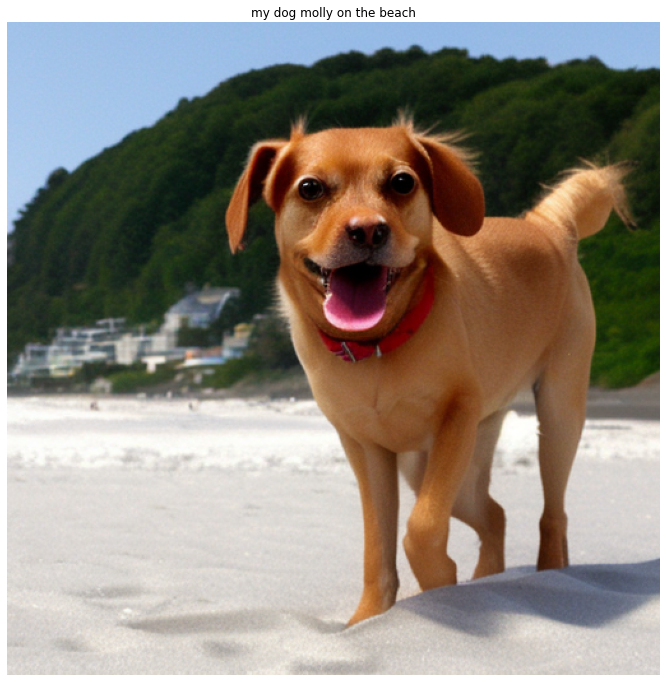

In [12]:
text = "my dog molly on the beach"
query_response = query(model_predictor, text)
img, prmpt = parse_response(query_response)
display_img_and_prompt(img, prmpt)

Because Stable Diffusion does not have any knowledge on Molly the dog, it's attempting to generate a picture of any dog on a beach.  Let's see how we can fine-tune Stable Diffusion to utilize a custom subject, in this case Molly. 

### 2.8. Clean up the endpoint

In [13]:
# Delete the SageMaker endpoint
model_predictor.delete_model()
model_predictor.delete_endpoint()

## 3. Fine-tune the pre-trained model on a custom dataset

---
Previously, we saw how to run inference on a pre-trained model. Next, we discuss how a model can be finetuned to a custom dataset with any number of classes.

The model can be fine-tuned to any dataset of images. It works very well even with as little as five training images.

The fine-tuning script is built on the script from [dreambooth](https://dreambooth.github.io/). The model returned by fine-tuning can be further deployed for inference. Below are the instructions for how the training data should be formatted.

- **Input:** A directory containing the instance images, `dataset_info.json` and (optional) directory `class_data_dir`.
  - Images may be of `.png` or `.jpg` or `.jpeg` format.
  - `dataset_info.json` file must be of the format {'instance_prompt':<<instance_prompt>>,'class_prompt':<<class_prompt>>}.
  - If with_prior_preservation = False, you may choose to ignore 'class_prompt'.
  - `class_data_dir` directory must have class images. If with_prior_preservation = True and class_data_dir is not present or there are not enough images already present in class_data_dir, additional images will be sampled with class_prompt.
- **Output:** A trained model that can be deployed for inference.

The s3 path should look like `s3://bucket_name/input_directory/`. Note the trailing `/` is required.

Here is an example format of the training data.

    input_directory
        |---instance_image_1.png
        |---instance_image_2.png
        |---instance_image_3.png
        |---instance_image_4.png
        |---instance_image_5.png
        |---dataset_info.json
        |---class_data_dir
            |---class_image_1.png
            |---class_image_2.png
            |---class_image_3.png
            |---class_image_4.png

**Prior preservation, instance prompt and class prompt:** Prior preservation is a technique that uses additional images of the same class that we are trying to train on.  For instance, if the training data consists of images of a particular dog, with prior preservation, we incorporate class images of generic dogs. It tries to avoid overfitting by showing images of different dogs while training for a particular dog. Tag indicating the specific dog present in instance prompt is missing in the class prompt. For instance, instance prompt may be "a photo of a riobugger cat" and class prompt may be \"a photo of a cat\". You can enable prior preservation by setting the hyper-parameter with_prior_preservation = True.


We provide default datasets of cat and dogs images. Cat dataset consists of eight images (instance images corresponding to instance prompt) of a single cat with no class images. It can be downloaded from [here](https://github.com/marshmellow77/dreambooth-sm/tree/main/training-images). If using the cat dataset, try the prompt "a photo of a riobugger cat" while doing inference in the demo notebook. Dog dataset consists of 12 images of a single dog with no class images. If using the dog dataset, try the prompt "a photo of a Doppler dog" while doing inference in the demo notebook.

License: [MIT](https://github.com/marshmellow77/dreambooth-sm/blob/main/LICENSE).

### 3.1. Retrieve Training Artifacts

---
Here, we retrieve the training docker container, the training algorithm source, and the pre-trained base model. Note that model_version="*" fetches the latest model.

---

In [14]:
from sagemaker import image_uris, model_uris, script_uris

# Currently, not all the stable diffusion models in jumpstart support finetuning. Here, we manually select a model
# which supports finetuning.
train_model_id, train_model_version, train_scope = (
    "model-txt2img-stabilityai-stable-diffusion-v2-1-base",
    "*",
    "training",
)

# Tested with ml.g4dn.2xlarge (16GB GPU memory) and ml.g5.2xlarge (24GB GPU memory) instances. Other instances may work as well.
# If ml.g5.2xlarge instance type is available, please change the following instance type to speed up training.
training_instance_type = instance_types.retrieve_default(
    region=None,
    model_id=train_model_id,
    model_version=train_model_version,
    scope=train_scope
)

# Retrieve the docker image
train_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    model_id=train_model_id,
    model_version=train_model_version,
    image_scope=train_scope,
    instance_type=training_instance_type,
)

# Retrieve the training script. This contains all the necessary files including data processing, model training etc.
train_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope=train_scope
)
# Retrieve the pre-trained model tarball to further fine-tune
train_model_uri = model_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, model_scope=train_scope
)

print(training_instance_type)

ml.g4dn.8xlarge


### 3.2. Set Training parameters

---
Now that we are done with all the set up that is needed, we are ready to train our stable diffusion model. To begin, let us create a [``sageMaker.estimator.Estimator``](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html) object. This estimator will launch the training job.


There are two kinds of parameters that need to be set for training. The first one are the parameters for the training job. These include:
- Training data path. This is S3 folder in which the input data is stored.
- Output path: This the s3 folder in which the training output is stored.
- Training instance type: This indicates the type of machine on which to run the training. We defined the training instance type above to fetch the correct train_image_uri.
- Metric definitions: A list of dictionaries that define the metrics used to evaluate the training job. Default values are retrieved from the SageMaker SDK.

The second set of parameters are algorithm specific training hyper-parameters.

---

In [24]:
import sagemaker.metric_definitions
# Sample training data is available in this bucket

session_bucket = sess.default_bucket()

training_data_prefix = "stable-diffusion/dreambooth-finetuning/training_images/"

training_dataset_s3_path = f"s3://{session_bucket}/{training_data_prefix}"
print(training_dataset_s3_path)


output_prefix = "stable-diffusion/dreambooth-finetuning/"

# Retrieve the default metric definitions to emit to CloudWatch Logs\n",
metric_definitions = sagemaker.metric_definitions.retrieve_default(
    model_id=train_model_id, model_version=train_model_version,
)

output_s3_path = f"s3://{session_bucket}/{output_prefix}/output"
print(output_s3_path)


s3://sagemaker-us-east-1-511652778238/stable-diffusion/dreambooth-finetuning/training_images/
s3://sagemaker-us-east-1-511652778238/stable-diffusion/dreambooth-finetuning//output


Copy Molly images to S3

---
For algorithm specific hyper-parameters, we start by fetching python dictionary of the training hyper-parameters that the algorithm accepts with their default values. This can then be overridden to custom values.

---

In [42]:
from sagemaker import hyperparameters

# Retrieve the default hyper-parameters for fine-tuning the model
hyperparameters = hyperparameters.retrieve_default(
    model_id=train_model_id, model_version=train_model_version
)

# [Optional] Override default hyperparameters with custom values
hyperparameters["max_steps"] = "400"
print(hyperparameters)

{'epochs': '20', 'max_steps': '400', 'batch_size': '1', 'with_prior_preservation': 'False', 'num_class_images': '100', 'learning_rate': '2e-06', 'prior_loss_weight': '1.0', 'center_crop': 'False', 'lr_scheduler': 'constant', 'adam_weight_decay': '0.01', 'adam_beta1': '0.9', 'adam_beta2': '0.999', 'adam_epsilon': '1e-08', 'gradient_accumulation_steps': '1', 'max_grad_norm': '1.0', 'compute_fid': 'False', 'seed': '0'}


---
If setting `with_prior_preservation=True`, please use ml.g5.2xlarge instance type as more memory is required to generate class images. Currently, training on ml.g4dn.2xlarge instance type run into CUDA out of memory issue when setting `with_prior_preservation=True`.

---

### 3.3. Train with Automatic Model Tuning
---

Amazon SageMaker automatic model tuning, also known as hyperparameter tuning, finds the best version of a model by running many training jobs on your dataset using the algorithm and ranges of hyperparameters that you specify. It then chooses the hyperparameter values that result in a model that performs the best, as measured by a metric that you choose. We will use a HyperparameterTuner object to interact with Amazon SageMaker hyperparameter tuning APIs. Here we tune two hyper-parameters `learning_rate` and `max_steps`.

---

In [43]:
from sagemaker.tuner import IntegerParameter
from sagemaker.tuner import ContinuousParameter
from sagemaker.tuner import HyperparameterTuner


use_amt = True

hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(1e-7, 3e-6, "Linear"),
    "max_steps": IntegerParameter(50, 400, "Linear"),
}

### 3.4. Start Training
---

We start by creating the estimator object with all the required assets and then launch the training job. 

---

In [47]:
from sagemaker.estimator import Estimator
from sagemaker.utils import name_from_base
from sagemaker.tuner import HyperparameterTuner

training_job_name = name_from_base(f"stable-diffusion-dreambooth-{train_model_id}-transfer-learning")

# Create SageMaker Estimator instance
sd_estimator = Estimator(
    role=aws_role,
    image_uri=train_image_uri,
    source_dir=train_source_uri,
    model_uri=train_model_uri,
    entry_point="transfer_learning.py",  # Entry-point file in source_dir and present in train_source_uri.
    instance_count=1,
    instance_type=training_instance_type,
    max_run=360000,
    metric_definitions=metric_definitions,
    hyperparameters=hyperparameters,
    output_path=output_s3_path,
    base_job_name=training_job_name,
)


if use_amt:
    # Let estimator emit fid_score metric to AMT
    sd_estimator.set_hyperparameters(compute_fid="True")
    tuner_parameters = {
        "estimator": sd_estimator,
        "metric_definitions": [{"Name": "fid_score", "Regex": "fid_score=([-+]?\\d\\.?\\d*)"}],
        "objective_metric_name": "fid_score",
        "objective_type": "Minimize",
        "hyperparameter_ranges": hyperparameter_ranges,
        "max_jobs": 2,
        "max_parallel_jobs": 2,
        "strategy": "Bayesian",
        "base_tuning_job_name": training_job_name,
    }

    tuner = HyperparameterTuner(**tuner_parameters)
    tuner.fit({"training": training_dataset_s3_path}, logs=True)
else:
    # Launch a SageMaker Training job by passing s3 path of the training data
    sd_estimator.fit({"training": training_dataset_s3_path}, logs=True)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


..............................................................................................................................................................................................................................................................................................................................................................................................................................!


If you set `max_jobs=9` and `max_parallel_jobs=3` above, it takes around 60 mins on the default dataset when using automatic model tuning. If more quota for the training instance type is available, please increase the `max_parallel_jobs` to speed up the tuning.

### 3.5. Deploy and run inference on the fine-tuned model

---

A trained model does nothing on its own. We now want to use the model to perform inference. For this example, that means predicting the bounding boxes of an image. We follow the same steps as in [2. Run inference on the pre-trained model](#2.-Run-inference-on-the-pre-trained-model). We start by retrieving the jumpstart artifacts for deploying an endpoint. However, instead of base_predictor, we  deploy the `od_estimator` that we fine-tuned.

---

In [50]:
inference_instance_type = instance_types.retrieve_default(
    region=None,
    model_id=train_model_id,
    model_version=train_model_version,
    scope="inference"
)

# Retrieve the inference docker container uri
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    image_scope="inference",
    model_id=train_model_id,
    model_version=train_model_version,
    instance_type=inference_instance_type,
)

endpoint_name = name_from_base(f"sd-finetuning-dreambooth-{train_model_id}-")

# Use the estimator from the previous step to deploy to a SageMaker endpoint
finetuned_predictor = (tuner if use_amt else sd_estimator).deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    image_uri=deploy_image_uri,
    endpoint_name=endpoint_name,
)


2023-09-07 23:59:14 Starting - Preparing the instances for training
2023-09-07 23:59:14 Downloading - Downloading input data
2023-09-07 23:59:14 Training - Training image download completed. Training in progress.
2023-09-07 23:59:14 Uploading - Uploading generated training model
2023-09-07 23:59:14 Completed - Resource released due to keep alive period expiry
---------!

Next, we query the finetuned model, parse the response and display the generated image. Functions for these are implemented in sections [2.3. Query endpoint and parse response](#2.3.-Query-endpoint-and-parse-response). Please execute those cells.

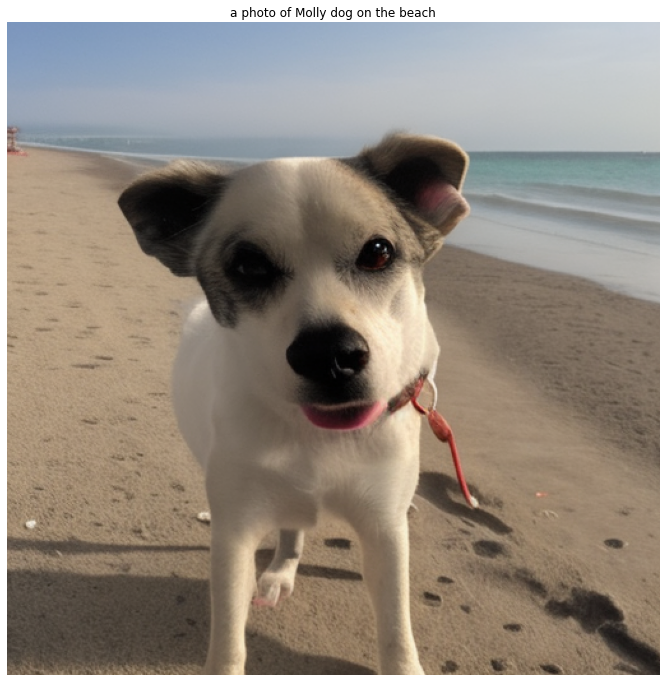

In [56]:
text = "a photo of Molly dog on the beach"
query_response = query(finetuned_predictor, text)
img, prmpt = parse_response(query_response)
display_img_and_prompt(img, prmpt)

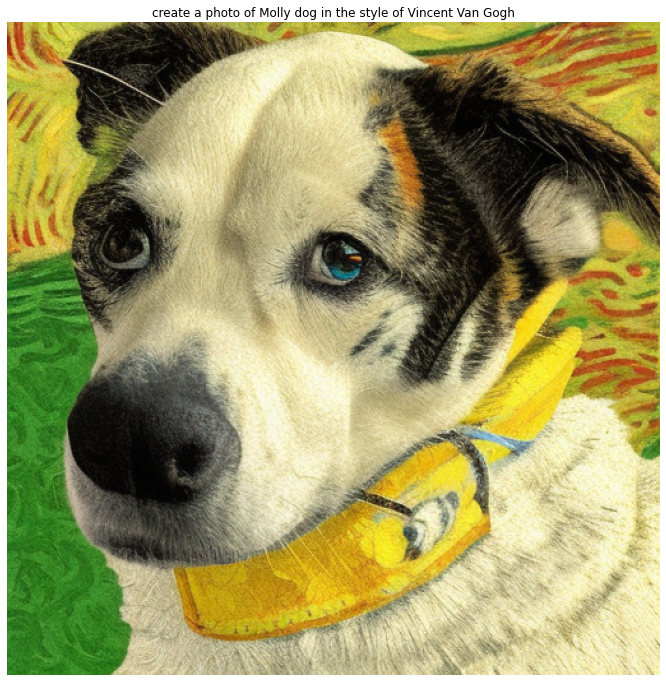

In [57]:
text = "create a photo of Molly dog in the style of Vincent Van Gogh"
query_response = query(finetuned_predictor, text)
img, prmpt = parse_response(query_response)
display_img_and_prompt(img, prmpt)

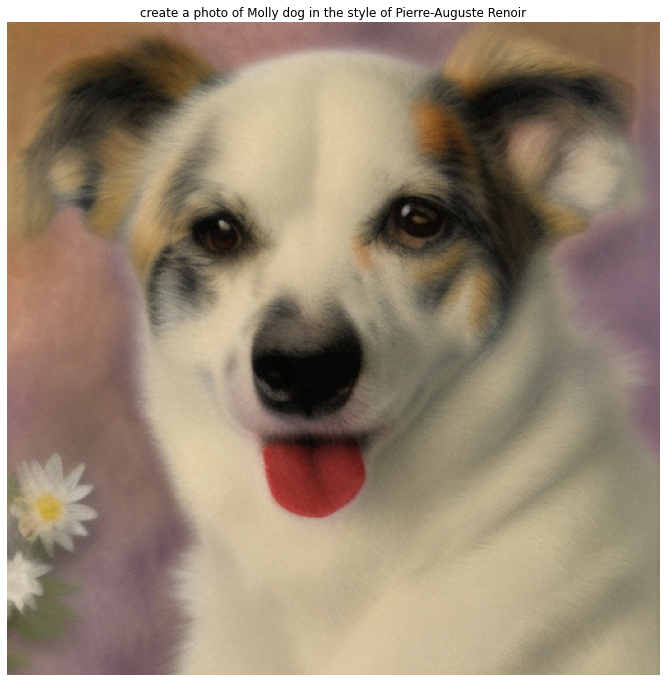

In [59]:
text = "create a photo of Molly dog in the style of Pierre-Auguste Renoir"
query_response = query(finetuned_predictor, text)
img, prmpt = parse_response(query_response)
display_img_and_prompt(img, prmpt)

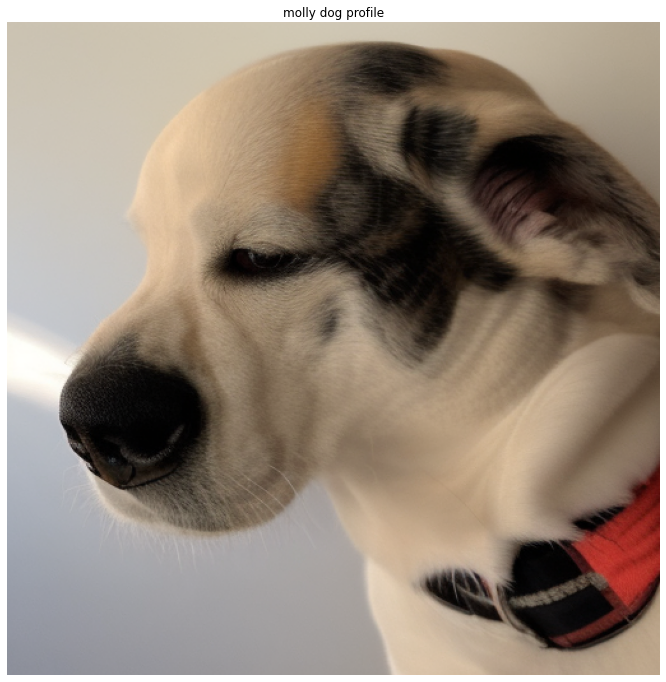

In [63]:
text = "molly dog profile"
query_response = query(finetuned_predictor, text)
img, prmpt = parse_response(query_response)
display_img_and_prompt(img, prmpt)

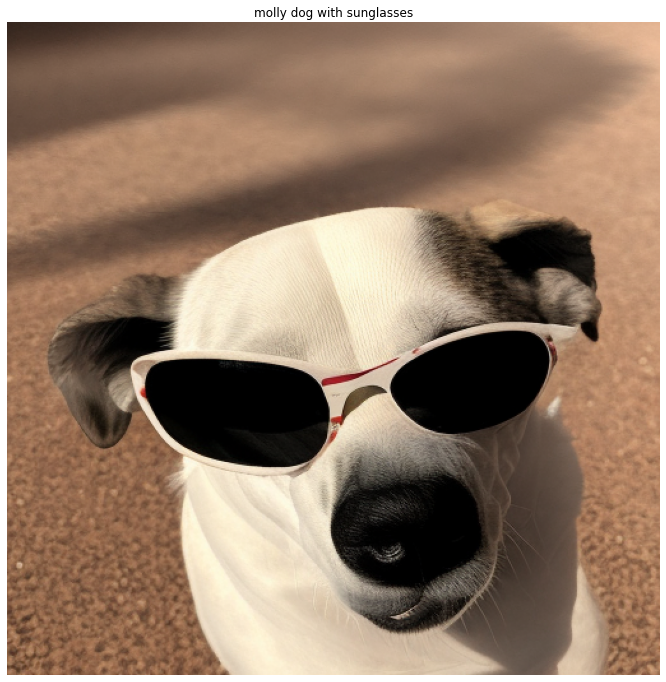

In [61]:
text = "molly dog with sunglasses"
query_response = query(finetuned_predictor, text)
img, prmpt = parse_response(query_response)
display_img_and_prompt(img, prmpt)

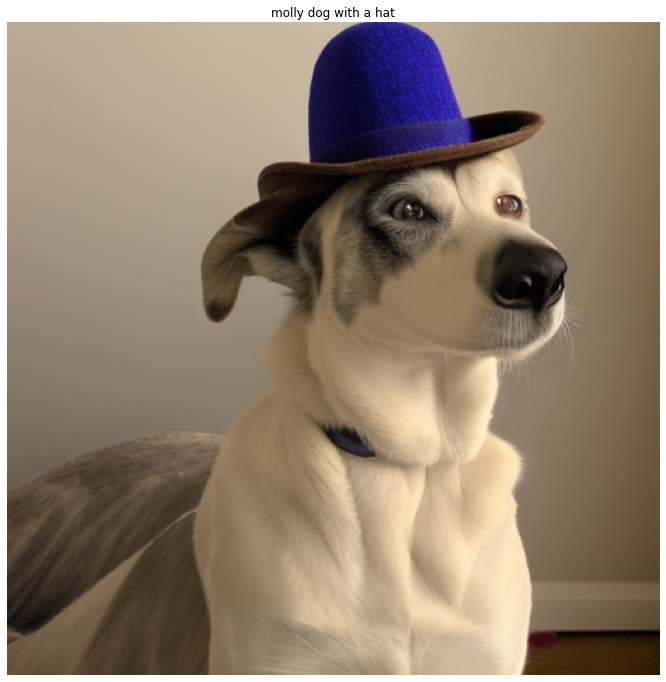

In [62]:
text = "molly dog with a hat"
query_response = query(finetuned_predictor, text)
img, prmpt = parse_response(query_response)
display_img_and_prompt(img, prmpt)

All the parameters mentioned in [2.4. Supported Inference parameters](#2.4.-Supported-Inference-parameters) are supported with finetuned model as well. You may also receive compressed image output as in [2.5. Compressed Image Output](#2.5.-Compressed-Image-Output) by changing `accept`.

---
Next, we delete the endpoint corresponding to the finetuned model.

---

In [ ]:
# Delete the SageMaker endpoint
finetuned_predictor.delete_model()
finetuned_predictor.delete_endpoint()

### 4. Conclusion
---
In this tutorial, we learnt how to deploy a pre-trained Stable Diffusion model on SageMaker using JumpStart. We saw that Stable Diffusion models can generate highly photo-realistic images from text.  JumpStart provides both Stable Diffusion 1 and Stable Diffusion 2 and their FP16 revisions. JumpStart also provides additional 84 diffusion models which have been trained to generate images from different themes and different languages. You can deploy any of these models without writing any code of your own.  To deploy a specific model, you can select a `model_id` in the dropdown menu in [2.1. Select a Model](#2.1.-Select-a-Model).

You can tweak the image generation process by selecting the appropriate parameters during inference. Guidance on how to set these parameters is provided in [2.4. Supported Inference parameters](#2.4.-Supported-Inference-parameters). We also saw how returning a large image payload can lead to response size limit issues. JumpStart handles it by encoding the image at the endpoint and decoding it in the notebook before displaying. Finally, we saw how prompt engineering is a crucial step in generating high quality images. We discussed how to set your own prompts and saw a some examples of good prompts.

To learn more about Inference on pre-trained Stable Diffusion models, please check out the blog [Generate images from text with the stable diffusion model on Amazon SageMaker JumpStart](https://aws.amazon.com/blogs/machine-learning/generate-images-from-text-with-the-stable-diffusion-model-on-amazon-sagemaker-jumpstart/)

Although creating impressive images can find use in industries ranging from art to NFTs and beyond, today we also expect AI to be personalizable. JumpStart provides fine-tuning capability to the pre-trained models so that you can adapt the model to your own use case with as little as five training images. This can be useful when creating art, logos, custom designs, NFTs, and so on, or fun stuff such as generating custom AI images of your pets or avatars of yourself. To learn more about Stable Diffusion fine-tuning, please check out the blog [Fine-tune text-to-image Stable Diffusion models with Amazon SageMaker JumpStart](https://aws.amazon.com/blogs/machine-learning/fine-tune-text-to-image-stable-diffusion-models-with-amazon-sagemaker-jumpstart/).